# Acquiring images (Module 3)

This notebook is designed to be a standalone tutorial demonstrating how you can acquire images from the [iDigBio portal](https://www.idigbio.org/portal/search) based on your own research scope. For the remainder of the lessons in today's workshop we will be using a standard set of images provided by the workshop instructors. This module will show you how that set of images was originally acquired, and provide an opportunity for you to test out downloading images yourself.

Our goals are for you to be able to:
1. Define search parameters
1. Retrieve specimen media records that meet those parameters
1. Download media associated with those specimen records
1. Review media and conduct quality control

We will be accessing data from the iDigBio Portal via an Application Programming Interface (API). All that you need to know about APIs for this workshop is that they are essentially a way for an organization to allow external users to interact with their systems. If you would like a slightly more detailed overview, check out this video on [Reading data directly into your analysis script: Introduction to APIs](https://vimeo.com/444924504).

Before we begin, you will need to install the following packages if you have not already:

In [ ]:
pip install idigbio

In [ ]:
pip install pandas

In [ ]:
pip install requests

We also need to connect Google Colab to our Google Drive. When you run the code block below, you will be prompted to sign in to a Google account and get a key code (opens in a new tab) to paste into this notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Define search parameters & retrieve specimen media records

First, we need to find all the media records for which we are interested in downloading media files. Do this using the `search_media` function from the idigbio package, which allows you to search for media records based on data contained in linked specimen records, like species or collecting locality. You can learn more about this function from the [iDigBio API documentation](https://github.com/iDigBio/idigbio-search-api/wiki) and [iDigBio Python package documentation](https://pypi.org/project/idigbio/). In this example, we want to search for images of herbarium specimens of species in the genus _Prunus_ that were collected in the United States.

In [ ]:
# Load idigbio package
import idigbio

# Load pandas package
import pandas

# Specify that we want to return results as a dataframe
api = idigbio.pandas()

# Execute the search with a limit on retrieving only 10 results
mediarecords = api.search_media(rq={'genus': 'prunus',
                                    'country': 'united states',
                                    'stateprovince': 'california',
                                    'hasImage': True},
                                limit = 10)

As a result of the code above, we now have a dataframe called `mediarecords`. Here's a peak into some of the important fields contained in this dataframe:

In [ ]:
mediarecords[['accessuri','rights','format','records']]

## Download media associated with these specimen records

Now that we know what media records are of interest to us, we need to isolate the URLs that link to the actual media files so that we can download them. In this example, we will demonstrate how to download files that are cached on the iDigBio server, as well as the original files hosted externally by the data provider. It is unlikely that you need to download two sets of images, so you can choose to execute either the steps related to "iDigBio" or to "external," depending on your preference.

_The code block below will assemble a vector of download URLs for media files on the iDigBio server._

In [ ]:
# Pull UUID values out of the `mediarecords` dataframe and into a list data structure
uuids = mediarecords.index.tolist()

# Set standard URL prefix for files cached on the iDigBio server
append_str = 'https://api.idigbio.org/v2/media/'

# Define a URL suffix to specify we want to download the webview size images.
# These are derivatives that iDigBio creates at 600px width + length adjusted
# proportionally to whatever it needs to be to preserve the correct aspect ratio.
# You can download higher resolution images by changing this string to '?size=fullsize'
suffix_str = '?size=webview'

# Create list of iDigBio media URLs by concatenating the prefix above with the UUID values from `mediarecords`
mediaurl_idigbio = [append_str + sub + suffix_str for sub in uuids]

# Show us what we just made
for i in mediaurl_idigbio: print(i)

_The code block below will assemble a vector of download URLs for data providers' original media files stored on external servers._

In [ ]:
# Create list of external media URLs by pulling values for `accessuri` out of `mediarecords`
mediaurl_external = mediarecords.accessuri.tolist()

# Show us what we just made
for i in mediaurl_external: print(i)

## Downloading images

We can use the download URLs that we assembled in the step above to go and download each media file. For clarity, we will place files in two different folders, based on whether we downloaded them from the iDigBio server or an external server.

We want to download these files onto our Google Drive so that we can access them later.

In [ ]:
# Navigate into your Google Drive to set up creating new directories in late steps
%cd drive/MyDrive/Colab\ Notebooks/

_The code blocks below will download media files from the iDigBio server and store them in a folder on your Google Drive._

When we download our images, we want to organize them in a way that facilitates research later on. One strategy for this is to keep your directory structure organized. We will exemplify this strategy by creating a new directory named with the image file source (iDigBio) and a reminder about the image content (_Prunus_).

In [ ]:
# Create new directory
!mkdir idigbio_prunus

In [ ]:
# Load requests package
import requests 

# Initiate loop that will iterate through our list of URLs and download the file found at each
for i in mediaurl_idigbio:

    # Define what values we are iterating through
    image_url = i
    
    # Define a filename based on the UUID of the media record
    filename = 'idigbio_prunus/' + image_url.split('/')[-1].replace('?size=webview','') + '.jpg'
    
    # Begin the process of downloading a file
    r = requests.get(image_url, stream = True)

    # Check that the file can be retrieved successfully
    if r.status_code == 200:
        
        # Set this otherwise the downloaded image file size will be zero
        r.raw.decode_content = True
    
        # Open a local file
        with open(filename, 'wb') as file:
            for block in r.iter_content(chunk_size = 1024):
                if block: 
                    file.write(block) 
        
        # Report back on how things went
        print('Image sucessfully Downloaded: ',filename)
    else:
        print('Image Couldn\'t be retreived')    

_The code block below will download media files hosted externally by data providers and store them in a folder on your Google Drive._

As with the iDigBio example above, we want to first create a new directory named with the image file source (external, in this case) and a reminder about the image content (_Prunus_).

In [ ]:
# Create new directory
!mkdir external_prunus

In [ ]:
# Load requests package
import requests

# Initiate loop that will iterate through our list of URLs and download the file found at each
for i in mediaurl_external:

    # Define what values we are iterating through
    image_url = i
    
    # Define a filename based on the UUID of the media record
    filename = 'external_prunus/' + image_url.split('/')[-1]    

    # Begin the process of downloading a file
    r = requests.get(image_url, stream = True)

    # Check that the file can be retrieved successfully
    if r.status_code == 200:
        
        # Set this otherwise the downloaded image file size will be zero
        r.raw.decode_content = True
    
        # Open a local file
        with open(filename, 'wb') as file:
            for block in r.iter_content(chunk_size = 1024):
                if block: 
                    file.write(block)
        
        # Report back on how things went
        print('Image sucessfully Downloaded: ',filename)
    else:
        print('Image Couldn\'t be retreived')

## Reviewing media and conducting quality control

Once you have acquired your images, you should do a quality control check prior to feeding them into any machine learning application. After all, garbage in = garbage out! Here are a couple examples of tasks that might be included in your quality control workflow:
1. Browse through your images manually to visually assess content. Discard any images that are not relevant (e.g. picturing a label rather than a specimen).

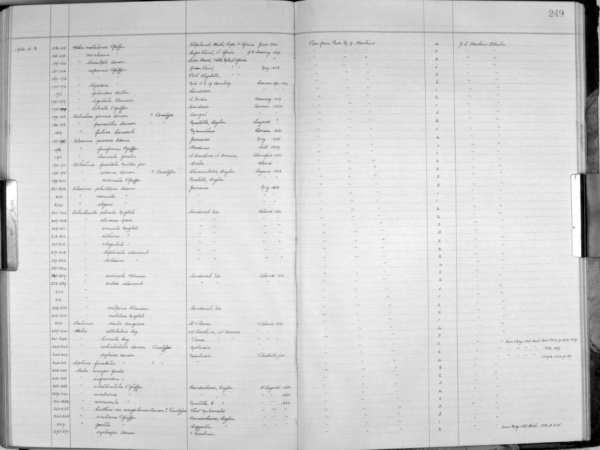

2. Deal with corrupted EXIF data.